# Base Imports

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer
import tensorflow_hub as hub
import spacy
import matplotlib.pyplot as plt
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\joaco\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\joaco\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
def plot_metrics(history, metrics = ['accuracy', 'F1']):
  plt.figure(figsize=(14, 10))
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.history[metric], color=colors[0], label='train')
    plt.plot(history.history['val_'+metric],
             color=colors[0], linestyle="--", label='val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

# Load Data

In [3]:
TRAIN_SIZE = 0.85
PATH = 'data/'

#"Odio", "Mujeres", "Comunidad LGBTQ+", "Comunidades Migrantes", "Pueblos Originarios"
classes = ["Mujeres", "Comunidad LGBTQ+", "Comunidades Migrantes", "Pueblos Originarios"]
data_train = pd.read_csv(PATH+'tweets_train.csv')

train_data = data_train.sample(frac=1).reset_index(drop=True)
train_data, val_data = train_data.iloc[:int(TRAIN_SIZE*len(train_data)), :], train_data.iloc[int(TRAIN_SIZE*len(train_data)):, :]

print(train_data.shape)
print(val_data.shape)

(1917, 10)
(339, 10)


# Exploración de datos

In [4]:
from random import randint

row_num = data_train.shape[0]
initial = randint(0, row_num-5)
for i in range(initial, initial+5):
    print("Tweet", i+1)
    print(data_train["text"].iloc[i])
    print("Odio:", data_train["Odio"].iloc[i], " "
          "Mujeres:", data_train["Mujeres"].iloc[i], " "
          "LGBT:", data_train["Comunidad LGBTQ+"].iloc[i], " ",
          "Migrantes:", data_train["Comunidades Migrantes"].iloc[i], " ",
          "Pueblos Originarios:", data_train["Pueblos Originarios"].iloc[i])
    print()

Tweet 1097
Ojalá un súper poder para hacer que las mujeres se puto callen la boca cuando me salga de los huevos,sería el mejor súper poder de la historia
Odio: 3  Mujeres: 3  LGBT: 0   Migrantes: 0   Pueblos Originarios: 0

Tweet 1098
Que metidas son la puta madre, no podes tw nada ni tirarte un pedo que todo el mundo salta a responderte. si no sabes lo que carajo me pasa, paso o lo que sea cerra el ogt y listo, PORQUE TODO EL MUNDO SE METE EN LA VIDA DE LOS DEMAS, APRENDAN A NO METERSE.
Odio: 1  Mujeres: 1  LGBT: 0   Migrantes: 0   Pueblos Originarios: 0

Tweet 1099
@ferthorli Quería hacerme el que podía saber quien era, pero ni puta idea jajs
Odio: 0  Mujeres: 0  LGBT: 0   Migrantes: 0   Pueblos Originarios: 0

Tweet 1100
@biobio Merluzo amariconado, queman casas todos los días y camiones. Que más hace falta que pase?
Odio: 3  Mujeres: 0  LGBT: 3   Migrantes: 0   Pueblos Originarios: 2

Tweet 1101
Este wn cree que cuando caga está "menstruando" https://t.co/tisQDpTyQL
Odio: 1  Mujere

# Preprocess Data

## Nivel considerado odio

In [5]:
MIN_VOTOS = 2

if MIN_VOTOS == 3:
    # Considerar que un dato pertenece solo si las 3 personas pusieron que pertenece
    train_data['Odio'] = np.where(train_data['Odio'] == 3, 1, 0)
    val_data['Odio'] = np.where(val_data['Odio'] == 3, 1, 0)
    train_data['Mujeres'] = np.where(train_data['Mujeres'] == 3, 1, 0)
    val_data['Mujeres'] = np.where(val_data['Mujeres'] == 3, 1, 0)
    train_data['Comunidad LGBTQ+'] = np.where(train_data['Comunidad LGBTQ+'] == 3, 1, 0)
    val_data['Comunidad LGBTQ+'] = np.where(val_data['Comunidad LGBTQ+'] == 3, 1, 0)
    train_data['Comunidades Migrantes'] = np.where(train_data['Comunidades Migrantes'] == 3, 1, 0)
    val_data['Comunidades Migrantes'] = np.where(val_data['Comunidades Migrantes'] == 3, 1, 0)
    train_data['Pueblos Originarios'] = np.where(train_data['Pueblos Originarios'] == 3, 1, 0)
    val_data['Pueblos Originarios'] = np.where(val_data['Pueblos Originarios'] == 3, 1, 0)   
elif MIN_VOTOS == 2:
    train_data['Odio'] = np.where((train_data['Odio'] == 3) | (train_data['Odio'] == 2), 1, 0)
    val_data['Odio'] = np.where((val_data['Odio'] == 3) | (val_data['Odio'] == 2), 1, 0)
    train_data['Mujeres'] = np.where((train_data['Mujeres'] == 3) | (train_data['Mujeres'] == 2), 1, 0)
    val_data['Mujeres'] = np.where((val_data['Mujeres'] == 3) | (val_data['Mujeres'] == 2), 1, 0)
    train_data['Comunidad LGBTQ+'] = np.where((train_data['Comunidad LGBTQ+'] == 3) | (train_data['Comunidad LGBTQ+'] == 2), 1, 0)
    val_data['Comunidad LGBTQ+'] = np.where((val_data['Comunidad LGBTQ+'] == 3) | (val_data['Comunidad LGBTQ+'] == 2), 1, 0)
    train_data['Comunidades Migrantes'] = np.where((train_data['Comunidades Migrantes'] == 3) | (train_data['Comunidades Migrantes'] == 2), 1, 0)
    val_data['Comunidades Migrantes'] = np.where((val_data['Comunidades Migrantes'] == 3) | (val_data['Comunidades Migrantes'] == 2), 1, 0)
    train_data['Pueblos Originarios'] = np.where((train_data['Pueblos Originarios'] == 3) | (train_data['Pueblos Originarios'] == 2), 1, 0)
    val_data['Pueblos Originarios'] = np.where((val_data['Pueblos Originarios'] == 3) | (val_data['Pueblos Originarios'] == 2), 1, 0)
else:
    train_data['Odio'] = np.where(train_data['Odio'] >= 1, 1, 0)
    val_data['Odio'] = np.where(val_data['Odio'] >= 1, 1, 0)
    train_data['Mujeres'] = np.where(train_data['Mujeres'] >= 1, 1, 0)
    val_data['Mujeres'] = np.where(val_data['Mujeres'] >= 1, 1, 0)
    train_data['Comunidad LGBTQ+'] = np.where(train_data['Comunidad LGBTQ+'] >= 1, 1, 0)
    val_data['Comunidad LGBTQ+'] = np.where(val_data['Comunidad LGBTQ+'] >= 1, 1, 0)
    train_data['Comunidades Migrantes'] = np.where(train_data['Comunidades Migrantes'] >= 1, 1, 0)
    val_data['Comunidades Migrantes'] = np.where(val_data['Comunidades Migrantes'] >= 1, 1, 0)
    train_data['Pueblos Originarios'] = np.where(train_data['Pueblos Originarios'] >= 1, 1, 0)
    val_data['Pueblos Originarios'] = np.where(val_data['Pueblos Originarios'] >= 1, 1, 0)  


## Cleaning

In [6]:
import unidecode
import spacy_spanish_lemmatizer

stemmer = SnowballStemmer("spanish")
nlp = spacy.load("es_core_news_lg")
#nlp.replace_pipe("lemmatizer", "spanish_lemmatizer")
stop_words = stopwords.words("spanish")

def clean_text(text, len_words):
    TEXT_CLEANING_RE = "@\S+" # separado porque solo agarraba la primera etiqueta
    TEXT_CLEANING_RE2 = "https?:\S+|http?:\S|[^A-Za-z0-9]+"
    TEXT_CLEANING_RE_EXTRA = "[^\w\s]"
    if len_words == 1:
        text = re.sub(r'\b\w{1}\b', '', str(text).lower()).strip()
    elif len_words == 2:
        text = re.sub(r'\b\w{1,2}\b', '', str(text).lower()).strip()
    elif len_words == 3:
        text = re.sub(r'\b\w{1,3}\b', '', str(text).lower()).strip()
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    text = re.sub(TEXT_CLEANING_RE2, ' ', str(text).lower()).strip()
    text = re.sub(TEXT_CLEANING_RE_EXTRA, ' ', str(text).lower()).strip()
    return text

def preprocess(text,cleaning=True, stopwords=True, stemming=False, lemmatizer=False, len_words=1):
    text = unidecode.unidecode(text)
    if cleaning:
        text = clean_text(text, len_words)
    tokens = []
    for token in text.split():
        if (not stopwords) or (stopwords and (token not in stop_words)):
            if stemming:
                tokens.append(stemmer.stem(token))
            elif lemmatizer:
                doc = nlp(token)
                tokens.append(unidecode.unidecode(doc[0].lemma_))
            else:
                tokens.append(token)    
    text2 = " ".join(tokens)
    if cleaning:
        text2 = clean_text(text2, len_words)
    return text2

c:\Users\joaco\anaconda3\envs\conda_gpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Pruebas de preprocesado

In [7]:
import random

tweet = train_data['text'][random.randint(0, len(train_data))]
#tweet = "@jalessandri @RicardoVenegas7 @hola Estos wueones extranjero haitianos,peruanos, venezolanos y los más ladrones .cubanos .vinieron a echar el país,,,toda está gente vende en las calles y puras cochinadas como vendiendo almuerzo pobladas en la catedral fuera de este país por eso boto RECHAZO....."

print(tweet,"\n")  
print("Sin stopwords:",preprocess(tweet, stopwords=False))
print("Con stemming:",preprocess(tweet, cleaning=True, stopwords=False, stemming=True))
print("Con lematizacion:",preprocess(tweet, cleaning=True, stopwords=False, stemming=False, lemmatizer=True, len_words=1))

Mapuches maricones cómo se les ocurre, dispararle a una menor de 9 años , piden y piden ya soltaron al delincuente del Celestino , MAPUCHES DE MIERDA 

Sin stopwords: mapuches maricones como se les ocurre dispararle una menor de anos piden piden ya soltaron al delincuente del celestino mapuches de mierda
Con stemming: mapuch maricon com se les ocurr dispar una menor de anos pid pid ya solt al delincuent del celestin mapuch de mierd
Con lematizacion: mapuch maricon como el el ocurrir disparar el uno menor de ano pedir pedir ya soltar al delincuente del celestino mapuch de mierda


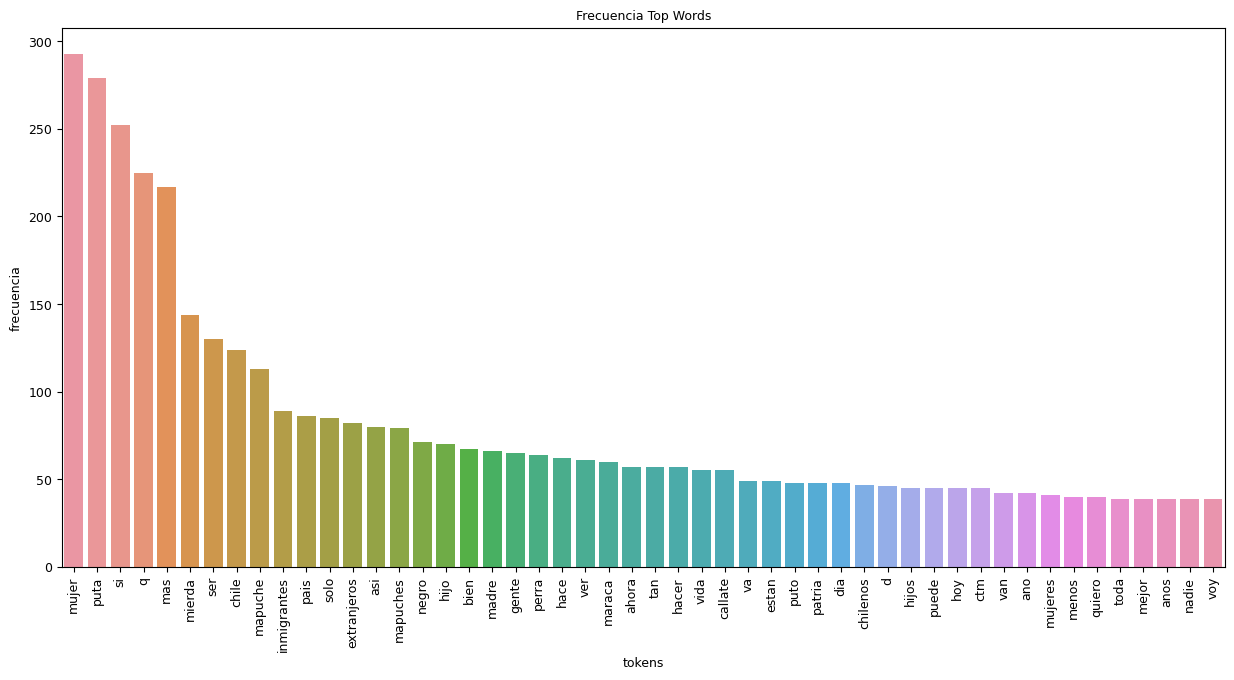

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

n_top_words = 50

tweets= [preprocess(tweet, cleaning=True, stopwords=True, stemming=False, lemmatizer=False, len_words=0).split() for tweet in train_data['text'].values]

top_words = Counter([item for sublist in [tweet for tweet in tweets] for item in sublist]).most_common(n_top_words)

fig, ax = plt.subplots(figsize=(15,7),nrows=1)
ax.set_title('Frecuencia Top Words',fontsize=9)
sns.barplot(x=[w[0] for w in top_words], y=[w[1] for w in top_words])
ax.set_xlabel("tokens",fontsize=9)
ax.set_ylabel("frecuencia",fontsize=9)
ax.tick_params(axis='both', which='major', labelsize=9)
plt.xticks(rotation=90)
plt.show()

# Definición de modelo y datos a usar

In [9]:
CLEANING = True
STOPWORDS = True
STEMMING = False
LEMMATIZER = False
LEN_WORDS = 2

train_tweets = [preprocess(tweet, cleaning=CLEANING, stopwords=STOPWORDS, stemming=STEMMING, lemmatizer=LEMMATIZER, len_words=LEN_WORDS) for tweet in train_data['text'].values]
val_tweets = [preprocess(tweet) for tweet in val_data['text'].values]
y_train_categorias = train_data[classes].values
y_val_categorias = val_data[classes].values

print(y_train_categorias.shape)
print(y_val_categorias.shape)

(1917, 4)
(339, 4)


In [10]:
import tensorflow_addons as tfa
METRICS = [
      tf.metrics.BinaryAccuracy(name='accuracy'),
      tfa.metrics.F1Score(name='F1', average='macro', num_classes=len(classes)),
      tf.metrics.Recall(name='recall')
]

c:\Users\joaco\anaconda3\envs\conda_gpu\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [11]:
from transformers import BertTokenizer

mbert_path = "https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/4"
encoder = hub.KerasLayer(mbert_path, trainable=True)

#bert_tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
vocab_file = encoder.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = encoder.resolved_object.do_lower_case.numpy()
bert_tokenizer = BertTokenizer(vocab_file, do_lower_case)
max_seq_len=50

In [12]:
#def prepare_input_for_mbert(texts, bert_tokenizer, max_seq_len):
#  x, y, z =[], [], []
#  for text in texts:
#    tokens = bert_tokenizer.tokenize(text)
#    tokens = tokens[:min(len(tokens),max_seq_len-2)]
#    tokens = ["[CLS]"]+tokens+["[SEP]"]
#    token_ids = bert_tokenizer.convert_tokens_to_ids(tokens)
#    input_ids = token_ids + [0] * (max_seq_len-len(token_ids))
#    input_mask = ([1] * len(token_ids)) + ([0] *  (max_seq_len - len(token_ids)))
#    input_type = ([0] * (len(token_ids)-1)) + [1] + ([0] *  (max_seq_len - len(token_ids)))
#    x.append(np.array(input_ids))
#    y.append(np.array(input_mask))
#    z.append(np.array(input_type))
#  return [tf.cast(np.array(x),tf.int32), tf.cast(np.array(y),tf.int32), tf.cast(np.array(z),tf.int32)]

def prepare_input_for_mbert(texts, bert_tokenizer, max_seq_len):
  x, y, z =[],[], []
  for text in texts:
    tokens = bert_tokenizer.tokenize(text)
    tokens = tokens[:min(len(tokens),max_seq_len-2)]
    tokens = ["[CLS]"]+tokens+["[SEP]"]
    token_ids = bert_tokenizer.convert_tokens_to_ids(tokens)
    input_ids = token_ids + [0] * (max_seq_len-len(token_ids))
    input_mask = ([1] * len(token_ids)) + ([0] *  (max_seq_len - len(token_ids)))
    input_type = ([0] * (len(token_ids)-1)) + [1] + ([0] *  (max_seq_len - len(token_ids)))
    x.append(np.array(input_ids))
    y.append(np.array(input_mask))
    z.append(np.array(input_type))
  return [tf.cast(np.array(x),tf.int32), tf.cast(np.array(y),tf.int32), tf.cast(np.array(z),tf.int32)]

In [13]:
bert_input_train = prepare_input_for_mbert(train_tweets,bert_tokenizer,max_seq_len)
bert_input_val = prepare_input_for_mbert(val_tweets,bert_tokenizer,max_seq_len)
print(bert_input_train[1].shape)
print(max_seq_len)

(1917, 50)
50


In [14]:
print(bert_input_train[2][101])
print(train_tweets)

tf.Tensor(
[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(50,), dtype=int32)
['mapuche haitiano espera mas', 'mapuche terrorista puto', 'mapuches mierda puta van chile prender fuego tomar tierras hijos putas', 'extranjeros tiran tiran mugre chatos gente llenas aceite calles chilenos pagamos dividendos impuestos gente cree duenos lugar vivimos favor ahora acercamos nuevo presidente recuperar chile', 'toda venezuela deseo mejor ano 2019 nuevo ano arranca oportunidad continuar luchando hermosa patria feliz ano 2019', 'enferma agradecer ladron tirano comunista regado mundo venezolanos menos chile vamos devolver cuantos millones retorno firmo burric puede lleva inmigrantes ilegales', 'senora ministra verdad verdad mujer solo queria darle aceite sol equivoco manera pregudicar mujer ganado cuantas ministerio pueden decirlo depender honb', 'importante recordar bastarda qla', 'sigan cayendo terroristas bien habitantes araucania', '

In [15]:
def mbert_model(seq_length, classes): 
    encoder_inputs = dict(
        input_word_ids=tf.keras.layers.Input(shape=(seq_length,), dtype=tf.int32),
        input_mask=tf.keras.layers.Input(shape=(seq_length,), dtype=tf.int32),
        input_type_ids=tf.keras.layers.Input(shape=(seq_length,), dtype=tf.int32),
    )
    outputs = encoder(encoder_inputs)
    pooled_output = outputs["pooled_output"]      # [batch_size, 768].
    sequence_output = outputs["sequence_output"]  # [batch_size, seq_length, 768].
    cls_out = keras.layers.GlobalAveragePooling1D()(sequence_output)
    logits = keras.layers.Dropout(0.7)(cls_out)
    logits = keras.layers.Dense(768)(logits)
    logits = keras.layers.Dropout(0.7)(logits)
    logits = keras.layers.Dense(len(classes), activation="softmax")(logits)
    classifier = keras.Model(encoder_inputs,logits)
    return classifier

In [16]:
mbert = mbert_model(50, classes)
mbert.summary()
mbert.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss=tf.keras.losses.BinaryFocalCrossentropy(),
    metrics = METRICS)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'encoder_outputs':  177853441   ['input_2[0][0]',                
                                 [(None, 50, 768),                'input_3[0][0]',            

# Entrenamiento

In [17]:
print(y_train_categorias[:10])

[[0 0 1 1]
 [0 0 0 1]
 [0 0 0 1]
 [0 0 1 0]
 [0 0 0 0]
 [0 0 1 0]
 [0 0 0 0]
 [1 0 0 0]
 [0 0 0 1]
 [1 0 0 0]]


In [19]:
tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.75)

if len(classes) == 1:
    metrica_monitoreada = 'val_accuracy'
else:
    metrica_monitoreada = 'val_F1'

print("metrica monitoreada", metrica_monitoreada)

checkpoint_path = 'BERT_based_checkpoints/BERT_based.{epoch:02d}-{val_F1:.4f}.h5'
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,save_weights_only=True,save_best_only=True,monitor=metrica_monitoreada,mode='max')
es = tf.keras.callbacks.EarlyStopping(monitor=metrica_monitoreada, patience=5, restore_best_weights=True, mode='max')
history_mbert_model = mbert.fit(bert_input_train, y_train_categorias, epochs=80, batch_size=16, validation_data=(bert_input_val, y_val_categorias), callbacks=[es])

metrica monitoreada val_F1
Epoch 1/80
120/120 [==============================] - 19s 159ms/step - loss: 0.2007 - accuracy: 0.7737 - F1: 0.1679 - recall: 0.1160 - val_loss: 0.0871 - val_accuracy: 0.8739 - val_F1: 0.0896 - val_recall: 0.0000e+00
Epoch 2/80
120/120 [==============================] - 17s 143ms/step - loss: 0.1399 - accuracy: 0.8219 - F1: 0.1831 - recall: 0.0814 - val_loss: 0.0851 - val_accuracy: 0.8739 - val_F1: 0.0896 - val_recall: 0.0000e+00
Epoch 3/80
120/120 [==============================] - 17s 143ms/step - loss: 0.1182 - accuracy: 0.8397 - F1: 0.1900 - recall: 0.0206 - val_loss: 0.0854 - val_accuracy: 0.8739 - val_F1: 0.0896 - val_recall: 0.0000e+00
Epoch 4/80
120/120 [==============================] - 17s 146ms/step - loss: 0.1096 - accuracy: 0.8513 - F1: 0.1863 - recall: 0.0150 - val_loss: 0.0837 - val_accuracy: 0.8739 - val_F1: 0.0896 - val_recall: 0.0000e+00
Epoch 5/80
120/120 [==============================] - 18s 152ms/step - loss: 0.1041 - accuracy: 0.8567 - 

In [58]:
#mbert.save('MBERT_model/mbert_'+str(len(classes))+'class_F1-{:.4f}.h5'.format((history_mbert_model.history['val_F1'][-1])))

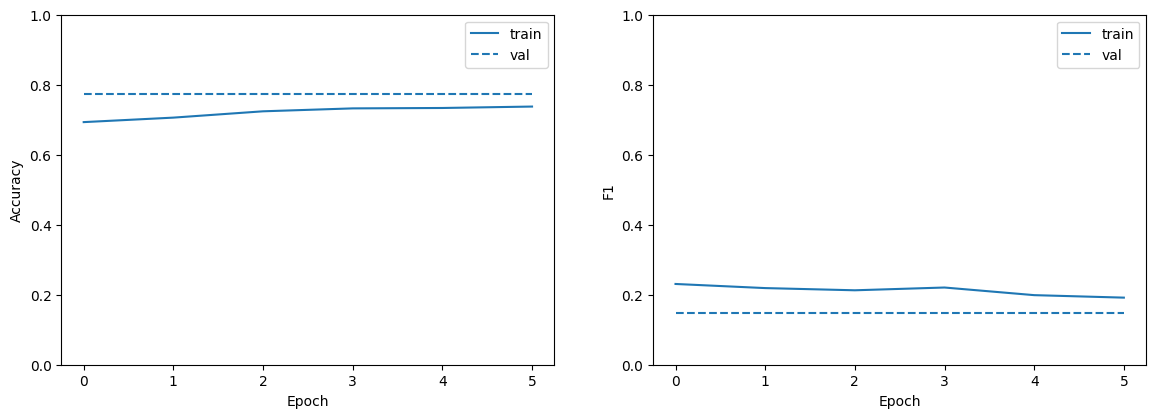

In [64]:
plot_metrics(history_mbert_model)

# Predicciones

In [20]:
test_data = pd.read_csv('data/public_test.csv')
test_tweets = [preprocess(tweet, cleaning=CLEANING, stopwords=STOPWORDS, stemming=STEMMING, lemmatizer=LEMMATIZER, len_words=LEN_WORDS) for tweet in test_data['text'].values]
bert_input_test = prepare_input_for_mbert(test_tweets,bert_tokenizer,max_seq_len)

y_pred_categorias = mbert.predict(bert_input_test)
for row in y_pred_categorias:
    for i in range(len(classes)):
        if row[i] > 0.5:
            row[i] = 1
        else:
            row[i] = 0
y_pred_categorias = pd.DataFrame(y_pred_categorias, columns=[classes])
y_pred_categorias["tweet_id"] = test_data["tweet_id"]
#y_pred_categorias.to_csv('predicciones.csv', index=False)
y_pred_categorias

72/72 [==============================] - 4s 53ms/step


,Mujeres,Comunidad LGBTQ+,Comunidades Migrantes,Pueblos Originarios,tweet_id
0,0.0,0.0,0.0,0.0,1533854540763742209
1,0.0,0.0,0.0,0.0,1277756504519725057
2,0.0,0.0,0.0,0.0,1529500412402757632
3,0.0,0.0,0.0,0.0,1167425893066838016
4,0.0,0.0,0.0,0.0,1399515878727749632
...,...,...,...,...,...
2286,0.0,0.0,0.0,0.0,1469006079782645762
2287,0.0,0.0,0.0,0.0,1528569883868508161
2288,0.0,0.0,0.0,0.0,1502776153001455616
2289,0.0,0.0,0.0,0.0,1540938860363907073


In [78]:
#!shutdown -s -t 60